### How does a playlist’s genre diversity affect its popularity?

In [123]:
import os
import json
import pickle
from collections import defaultdict
from collections import Counter
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [11]:
with open('mappings/Q1/playlist_dataMULTIPLE.pkl', 'rb') as fp:
    playlist_data = pickle.load(fp)

In [102]:
# cityblock 0, euclidean 1, braycurtis 2, cosine 3, minkowski 4, canberra 5
KEY = 0

In [103]:
# list(playlist_data.items())[:5]

In [104]:
div = np.asarray([np.asarray([x[1][0][KEY], x[1][1]]) for x in playlist_data.items()])

In [105]:
div.shape

(409039, 2)

In [106]:
MIN = np.min(div[:,0])
MAX = np.max(div[:,0])
num_bins = 5
w = (MAX-MIN)/num_bins
print(MIN,MAX,w)

1.9047109207708781 1.9996431120628144 0.01898643825838726


### Explore Diversity Metric

In [107]:
mask = [x[1] > 1 for x in div]
data = div[mask]

Text(0, 0.5, 'Number of Playlist With Score')

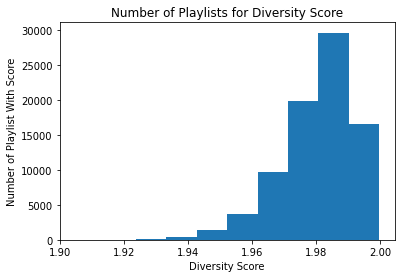

In [108]:
plt.hist(data[:,0])
plt.title('Number of Playlists for Diversity Score')
plt.xlabel('Diversity Score')
plt.ylabel('Number of Playlist With Score')


Text(0, 0.5, 'Followers')

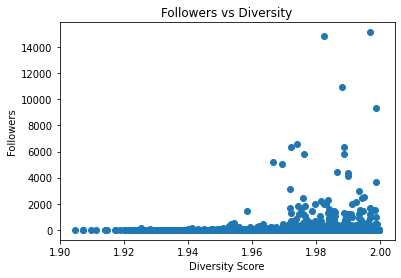

In [109]:
plt.scatter(data[:,0], data[:,1])
plt.title('Followers vs Diversity')
plt.xlabel('Diversity Score')
plt.ylabel('Followers')

In [110]:
np.max(data[:,1])

15123.0

In [111]:
def selector(a=np.min(div[:,1]),b=np.max(div[:,1]),c=np.min(div[:,0]),d=np.max(div[:,0])):
    m = [a < x[1] and x[1] <= b and c < x[0] and x[0] <= d for x in div]
    print(len(div[m]))
    data = div[m]
    return data

In [112]:
bins = np.arange(MIN,MAX+w,w)
bins = list(zip(bins, bins[1:]))
groups = [selector(a=1, c=s, d=e)[:,1] for s,e in bins]
groups = [g for g in groups if len(g) > 0]

19
491
5029
29545
46116
0


In [114]:
for ix, s in enumerate(bins):
    a,b = s
    if ix < len(groups):
        print('From {} to {}: {} Samples'.format(np.around(a,3), np.around(b,3), len(groups[ix])))

From 1.905 to 1.924: 19 Samples
From 1.924 to 1.943: 491 Samples
From 1.943 to 1.962: 5029 Samples
From 1.962 to 1.981: 29545 Samples
From 1.981 to 2.0: 46116 Samples


In [129]:
stat, p = stats.levene(*groups)
print(np.around(stat, 3), np.around(p, 3))

0.954 0.431


In [130]:
log_groups = [np.log(g) for g in groups]
stat, p = stats.levene(*log_groups)
print(np.around(stat, 3), np.around(p, 3))

31.945 0.0


In [131]:
# stat = stats.alexandergovern(*groups).statistic
# p = stats.alexandergovern(*groups).pvalue
stat, p = stats.f_oneway(*groups)
print(np.around(stat, 3), np.around(p, 3))

0.954 0.431


In [132]:
stat = stats.alexandergovern(*log_groups).statistic
p = stats.alexandergovern(*log_groups).pvalue
print(np.around(stat, 3), np.around(p, 3))

120.961 0.0


### Regression on Buckets

In [126]:
# table_arr = []
# for s,e in bins:
#     d = selector(a=1, c=s, d=e)
#     if len(d) == 0:
#         print('skipping', s, e)
#         continue
#     x = d[:,0]
#     y = d[:,1]
#     x2 = sm.add_constant(x)
#     lr = sm.OLS(y, x2).fit()
#     t = lr.tvalues[-1]
#     p = lr.pvalues[-1]
#     r, _ = stats.pearsonr(x,y)
#     print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
#                                             np.around(e,3),
#                                             np.around(t,3),
#                                             np.around(p,3),
#                                             np.around(r,3)))
#     table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
# s = ''
# for row in table_arr:
#     s += ' & '.join([str(x) for x in row])
#     s += '\\\ \n \hline \n'
# print()
# print(s)

In [128]:
table_arr = []
for s,e in bins:
    d = selector(a=1, c=s, d=e)
    if len(d) == 0:
        print('skipping', s, e)
        continue
    x = d[:,0]
    y = np.log(d[:,1])
    x2 = sm.add_constant(x)
    lr = sm.OLS(y, x2).fit()
    t = lr.tvalues[-1]
    p = lr.pvalues[-1]
    r, _ = stats.pearsonr(x,y)
    print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
                                            np.around(e,3),
                                            np.around(t,3),
                                            np.around(p,3),
                                            np.around(r,3)))
    table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
s = ''
for row in table_arr:
    s += ' & '.join([str(x) for x in row])
    s += '\\\ \n \hline \n'
print()
print(s)

19
 1.905 to 1.924 & 0.512 & 0.615 & 0.123
491
 1.924 to 1.943 & -1.481 & 0.139 & -0.067
5029
 1.943 to 1.962 & -1.801 & 0.072 & -0.025
29545
 1.962 to 1.981 & -3.247 & 0.001 & -0.019
46116
 1.981 to 2.0 & 3.133 & 0.002 & 0.015
0
skipping 1.9996431120628146 2.0186295503212017

1.905 to 1.924 & 0.512 & 0.615 & 0.123\\ 
 \hline 
1.924 to 1.943 & -1.481 & 0.139 & -0.067\\ 
 \hline 
1.943 to 1.962 & -1.801 & 0.072 & -0.025\\ 
 \hline 
1.962 to 1.981 & -3.247 & 0.001 & -0.019\\ 
 \hline 
1.981 to 2.0 & 3.133 & 0.002 & 0.015\\ 
 \hline 

